<a href="https://colab.research.google.com/github/Gabriela-Alcaide/Analise_de_Redes_Sociais/blob/main/ARS_Detec%C3%A7%C3%A3o_de_Bots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Leitura da Base de Dados e algumas importações.**

In [ ]:
!pip install pandas openpyxl
import pandas as pd
from google.colab import files
import pandas as pd

In [ ]:
# Fazer upload do arquivo .xlsm
uploaded = files.upload()

# Nome do arquivo (ajuste se necessário)
base_dados = list(uploaded.keys())[0]

# Ler o arquivo .xlsm
base = pd.read_excel(base_dados, engine='openpyxl', sheet_name='dados')

Saving base_de_dados.xlsm to base_de_dados.xlsm


# **Adaptar para formato numérico**

In [ ]:
# Handle.

from sklearn.preprocessing import LabelEncoder

In [ ]:
label_encoder = LabelEncoder()

In [ ]:
base['handle'] = label_encoder.fit_transform(base['handle'])

In [ ]:
# Variáveis binárias.

In [ ]:
# displayName.
for i, d in enumerate(base['displayName']):
  if pd.isna(d):
    base.at[i, 'displayName'] = 0
  else:
    base.at[i, 'displayName'] = 1

In [ ]:
# imagem_perfil
base['imagem_perfil'] = base['imagem_perfil'].map({'Sim': 1, 'Nao': 0})

# imagem_banner
base['imagem_banner'] = base['imagem_banner'].map({'Sim': 1, 'Nao': 0})

# tirar data_criacao
base = base.drop('data_criacao', axis=1)

In [ ]:
# sentimento_mais_frequente
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
sentimento_encoded = encoder.fit_transform(base[['sentimento_mais_frequente']])
df_encoded = pd.DataFrame(sentimento_encoded, columns=encoder.get_feature_names_out(['sentimento_mais_frequente']))
base = base.drop('sentimento_mais_frequente', axis=1)
base = pd.concat([base, df_encoded], axis=1)

In [ ]:
# classificacao
base['classificacao'] = base['classificacao'].map({'bot': 1, 'humano': 0})

# **Balanceamento do Conjunto de Treinamento**

In [ ]:
num_contas = len(base)

In [ ]:
num_contas

203

In [ ]:
# Linhas de usuários bots.
bots = base[base["classificacao"] == 1]

# Contando o número de bots
num_bots = len(bots)

In [ ]:
# % de bots.
prop_bots = (num_bots / num_contas) * 100

print(prop_bots)

28.57142857142857


In [ ]:
# Lista de usuários humanos.
humanos = base[base["classificacao"] == 0]

# Contando o número de bots
num_humanos = len(humanos)

In [ ]:
# % de humanos.
prop_humanos = 100 - prop_bots

print(prop_humanos)

71.42857142857143


Percebe-se que o Conjunto é desbalanceado: há 30% bots e 70% humanos.

In [ ]:
# Filtrar 70% dos bots, para compôr o conjunto de treinamento.
bots_treinamento = bots.sample(frac=0.7, random_state=0)

In [ ]:
len(bots_treinamento)

41

In [ ]:
# Filtrar a mesma quantidade de humanos, para complementar o conjunto de treinamento.
humanos_treinamento = humanos.sample(n=41, random_state=0)

In [ ]:
# Conjunto de treinamento.
treinamento = pd.concat([bots_treinamento, humanos_treinamento], axis=0, ignore_index=True)

In [ ]:
# Montar o conjunto de teste e validação com os usuários fora do treinamento.
todos_handles = set(base['handle'])
handles_treinamento = set(treinamento['handle'])

handles_teste = todos_handles - handles_treinamento

teste = base[base['handle'].isin(handles_teste)]

# **Executar Árvore de Decisão.**

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
# Separar o conjunto de treinamento entre variáveis X e Y.
x_treino = treinamento.drop('classificacao', axis=1)
y_treino = treinamento['classificacao']

In [ ]:
# Separar o conjunto de teste entre variáveis X e Y.
x_teste = teste.drop('classificacao', axis=1)
y_teste = teste['classificacao']

In [ ]:
!pip install scikit-learn

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

Modelo 01: Simples

In [ ]:
# Criar modelo.
model = DecisionTreeClassifier(random_state=0)

In [ ]:
# Treinar modelo.
model.fit(x_treino, y_treino)

DecisionTreeClassifier(random_state=0)

In [ ]:
# Fazer o modelo prever com base em x_teste.
y_pred = model.predict(x_teste)

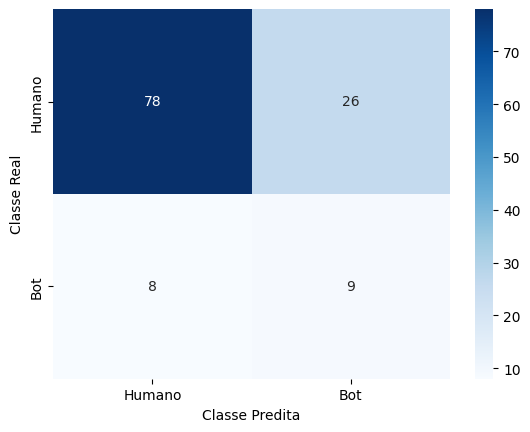

In [ ]:
# Matriz de confusão.
from sklearn.metrics import confusion_matrix

# Matriz de confusão
cm = confusion_matrix(y_teste, y_pred)

import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Humano', 'Bot'], yticklabels=['Humano', 'Bot'])
plt.ylabel('Classe Real')
plt.xlabel('Classe Predita')
plt.show()

In [ ]:
# Calcular acurácia.
accuracy = accuracy_score(y_teste, y_pred)
accuracy

0.71900826446281

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calcular precisão, recall e F1-score
precision = precision_score(y_teste, y_pred)
recall = recall_score(y_teste, y_pred)
f1 = f1_score(y_teste, y_pred)

# capacidade do modelo de não classificar erroneamente exemplos humanos como bots.
# classifica muitos humanos como bots.
print(f'Precisão: {precision:.2f}')

# capacidade do modelo de encontrar todos os bots.
print(f'Recall: {recall:.2f}')

# o mais útil.
print(f'F1-Score: {f1:.2f}')

Precisão: 0.26
Recall: 0.53
F1-Score: 0.35


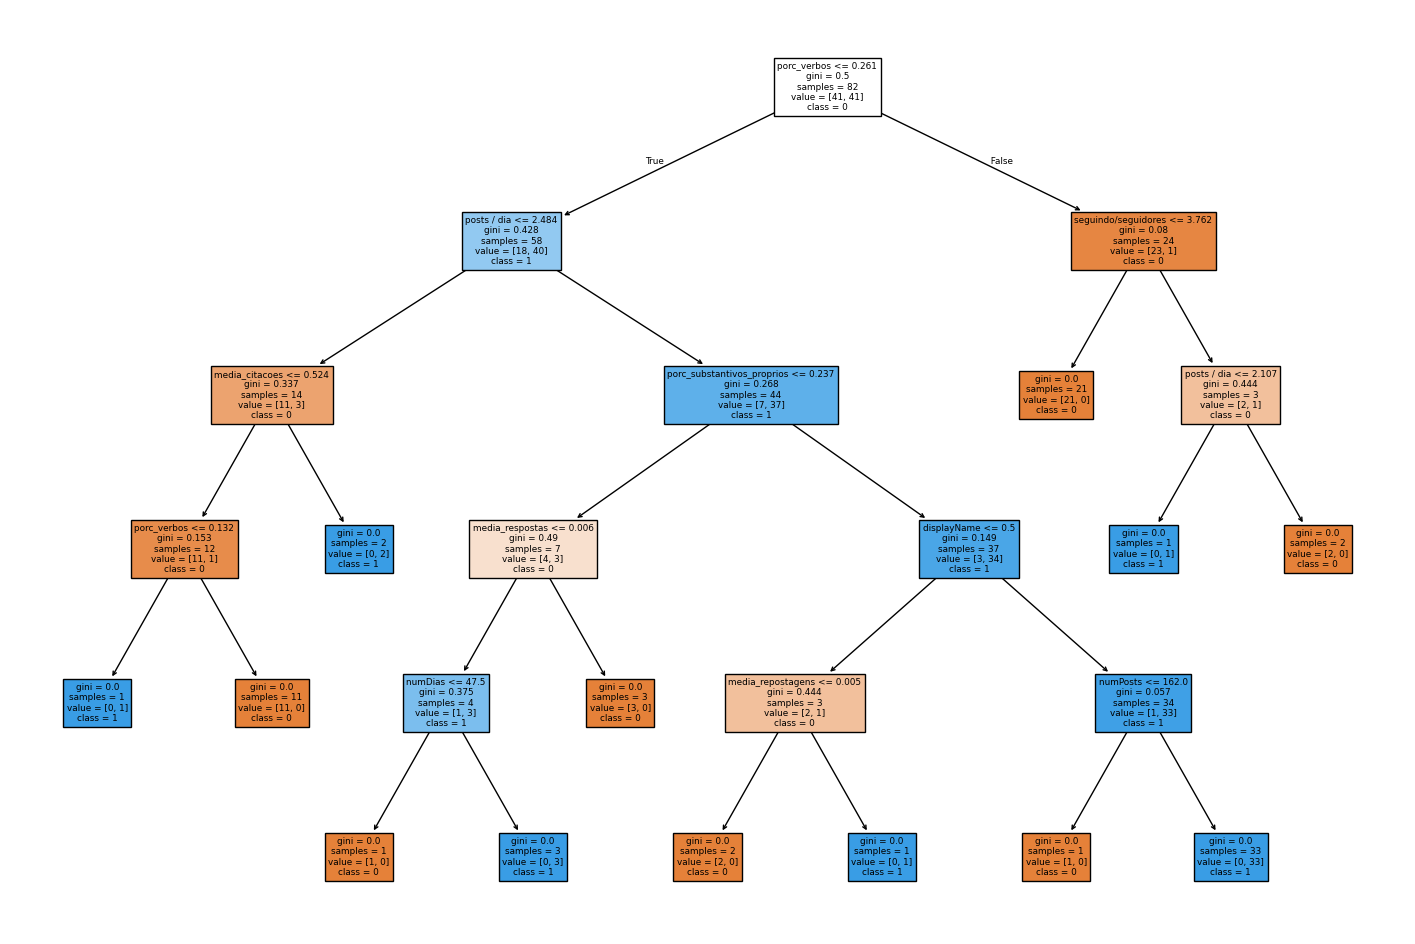

In [ ]:
# Visualizar a árvore.
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Plotar a árvore de decisão
plt.figure(figsize=(18, 12))
plot_tree(model, filled=True, feature_names=['handle', 'displayName', 'imagem_perfil', 'imagem_banner', 'numPosts', 'numDias', 'posts / dia', 'seguidores', 'seguindo', 'seguindo/seguidores', 'porc_substantivos_proprios', 'porc_substantivos_comuns', 'porc_verbos', 'porc_adjetivos', 'media_respostas', 'media_repostagens', 'media_curtidas', 'media_citacoes', 'sentimento_mais_frequente_NEGATIVE', 'sentimento_mais_frequente_POSITIVE'], class_names=['0', '1'])
plt.show()

Testando possibilidades.

In [ ]:
from itertools import product

In [ ]:
arvores = {}

possibilidades = {
    "altura": [1, 2, 3, 4, 5],
}

combinacoes = list(product(*possibilidades.values()))

for c in combinacoes:
  # Criar modelo.
  model = DecisionTreeClassifier(random_state=0, max_depth=c[0])
  # Treinar modelo.
  model.fit(x_treino, y_treino)
  # Fazer o modelo prever com base em x_teste.
  y_pred = model.predict(x_teste)
  # Calcular acurácia.
  accuracy = accuracy_score(y_teste, y_pred)
  # capacidade do modelo de não classificar erroneamente exemplos humanos como bots.
  # classifica muitos humanos como bots.
  precision = precision_score(y_teste, y_pred)
  # capacidade do modelo de encontrar todos os bots.
  recall = recall_score(y_teste, y_pred)
  # o mais útil.
  f1 = f1_score(y_teste, y_pred)
  arvores[f"Altura: {c[0]}"] = f"Acurácia: {accuracy:.2f}; precisão: {precision:.2f}; recall: {recall:.2f}; f1: {f1:.2f}"

In [ ]:
arvores

{'Altura: 1': 'Acurácia: 0.60; precisão: 0.25; recall: 0.88; f1: 0.38',
 'Altura: 2': 'Acurácia: 0.69; precisão: 0.26; recall: 0.65; f1: 0.37',
 'Altura: 3': 'Acurácia: 0.70; precisão: 0.26; recall: 0.59; f1: 0.36',
 'Altura: 4': 'Acurácia: 0.69; precisão: 0.25; recall: 0.59; f1: 0.35',
 'Altura: 5': 'Acurácia: 0.72; precisão: 0.26; recall: 0.53; f1: 0.35'}

# **Random Forest.**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Criar modelo.
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [ ]:
# Treinar o modelo
rf_model.fit(x_treino, y_treino)

RandomForestClassifier(random_state=42)

In [ ]:
# Fazer previsões
y_pred = rf_model.predict(x_teste)

In [ ]:
# Avaliar o desempenho
print("Acurácia:", accuracy_score(y_teste, y_pred))
print("\nMatriz de Confusão:\n", confusion_matrix(y_teste, y_pred))
print("\nRelatório de Classificação:\n", classification_report(y_teste, y_pred))

# Precisão: 86%
# Recall: 77%
# F1-score: 80%

Acurácia: 0.768595041322314

Matriz de Confusão:
 [[81 23]
 [ 5 12]]

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.94      0.78      0.85       104
           1       0.34      0.71      0.46        17

    accuracy                           0.77       121
   macro avg       0.64      0.74      0.66       121
weighted avg       0.86      0.77      0.80       121



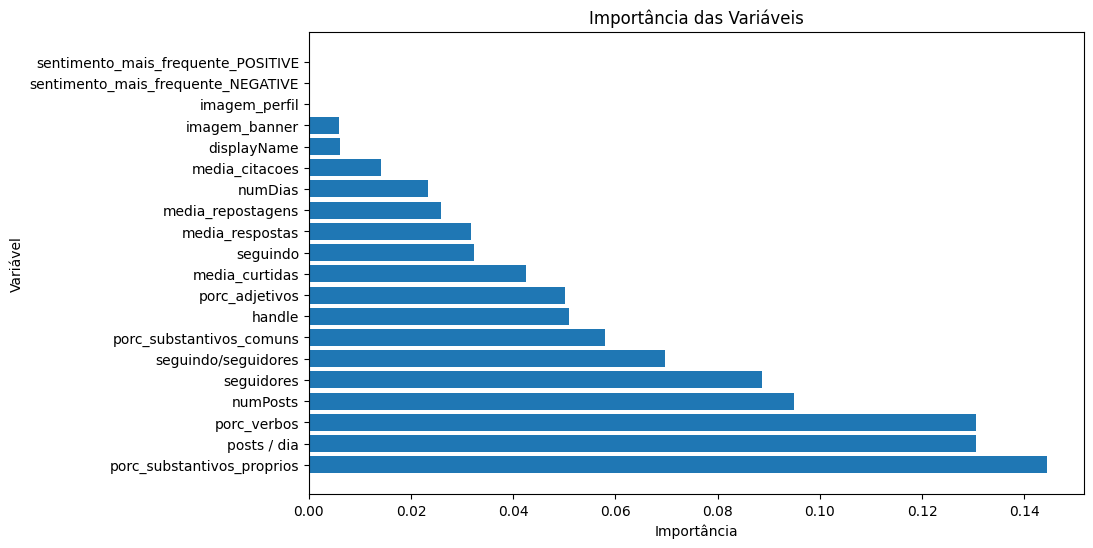

In [ ]:
# Importância das Variáveis

importances = rf_model.feature_importances_
feature_names = x_treino.columns
df_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Visualização
plt.figure(figsize=(10, 6))
plt.barh(df_importances['Feature'], df_importances['Importance'])
plt.xlabel('Importância')
plt.ylabel('Variável')
plt.title('Importância das Variáveis')
plt.show()


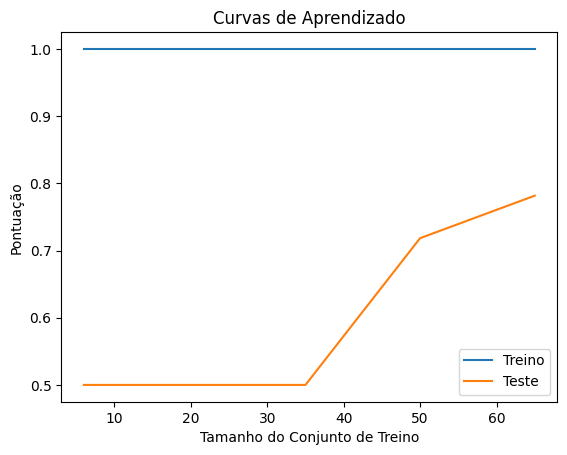

In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(rf_model, x_treino, y_treino, cv=5)
plt.plot(train_sizes, train_scores.mean(axis=1), label='Treino')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Teste')
plt.legend()
plt.xlabel('Tamanho do Conjunto de Treino')
plt.ylabel('Pontuação')
plt.title('Curvas de Aprendizado')
plt.show()


# **Regressão Logística.**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [ ]:
# Criando o Modelo.
model = LogisticRegression()

In [ ]:
# Treinando o modelo.
model.fit(x_treino, y_treino)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
# Fazer previsões.
y_pred = model.predict(x_teste)

In [ ]:
# Avaliar o modelo
print("Acurácia:", accuracy_score(y_teste, y_pred))
print("Relatório de Classificação:\n", classification_report(y_teste, y_pred))

# precisão: 78%
# recall: 69%
# f1-score: 75%

Acurácia: 0.6859504132231405
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.88      0.74      0.80       104
           1       0.18      0.35      0.24        17

    accuracy                           0.69       121
   macro avg       0.53      0.55      0.52       121
weighted avg       0.78      0.69      0.72       121



In [ ]:
# import pandas as pd
coef = pd.DataFrame({
    "Atributo": x_treino.columns,
    "Coeficiente": model.coef_[0]
}).sort_values(by="Coeficiente", ascending=False)
print(coef)

                              Atributo  Coeficiente
10          porc_substantivos_proprios     0.003564
1                          displayName     0.002477
4                             numPosts     0.001780
17                      media_citacoes     0.001275
7                           seguidores     0.000043
8                             seguindo     0.000027
19  sentimento_mais_frequente_POSITIVE     0.000000
2                        imagem_perfil    -0.000149
18  sentimento_mais_frequente_NEGATIVE    -0.000149
13                      porc_adjetivos    -0.000427
14                     media_respostas    -0.000510
11            porc_substantivos_comuns    -0.001383
12                         porc_verbos    -0.001903
3                        imagem_banner    -0.002177
15                   media_repostagens    -0.003906
9                  seguindo/seguidores    -0.005436
5                              numDias    -0.006277
0                               handle    -0.007093
16          

# **Naive Bayes - ComplementNB - Dados Desbalanceados.**

In [ ]:
from sklearn.naive_bayes import ComplementNB

In [ ]:
# Criar modelo.
model = ComplementNB()

In [ ]:
# Treinar modelo.
model.fit(x_treino, y_treino)

ComplementNB()

In [ ]:
# Fazer previsões
y_pred = model.predict(x_teste)

In [ ]:
# Avaliar o desempenho.
print("Acurácia:", accuracy_score(y_teste, y_pred))
print("\nRelatório de Classificação:\n", classification_report(y_teste, y_pred))

Acurácia: 0.7272727272727273

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.92      0.75      0.83       104
           1       0.28      0.59      0.38        17

    accuracy                           0.73       121
   macro avg       0.60      0.67      0.60       121
weighted avg       0.83      0.73      0.76       121

